In [1]:
# Imports
from pathlib import Path
from zipfile import ZipFile
from rich import print
# from skimage.io import imread
import massipipe
import matplotlib.pyplot as plt
from matplotlib.image import imread

from itertools import chain

In [2]:
# Parameters
example_image_number = 9
slice_row_index = 1700
point_row_index = 375
point_col_indices = [80,570]

In [3]:
# Paths (edit to correspond to local file placement)
hyspec_zip_path = Path("/home/mha114/data/seabee-minio/smola/maholmen/aerial/hsi/20230621/massimal_smola_maholmen_202306211129-2_hsi/processed/massimal_smola_maholmen_202306211129-2_hsi.zip")
annotations_zip_path = Path("/home/mha114/data/seabee-minio/smola/maholmen/aerial/hsi/20230621/massimal_smola_maholmen_20230621_hsi_annotation.zip")
data_root_dir = Path("/home/mha114/data/examples/glint_correction_1")
hyspec_dataset_dir = data_root_dir / hyspec_zip_path.stem

notebook_dir = Path("/home/mha114/code/github/massimal-dataset/examples")

In [4]:
# Paths part 2 (derived, do not edit) 
ann_root_dir = data_root_dir / "massimal_smola_maholmen_20230621_hsi_annotation/"
ann_dataset_name = "smola_maholmen_202306211129_2"
seg_mask_dir = ann_root_dir / "segmentation_masks" / ann_dataset_name
ann_rgb_dir = ann_root_dir / "rgb_images" / ann_dataset_name
label_json_path = seg_mask_dir.parent / "label_classes.json"

figures_dir = notebook_dir / "glint_correction_figures"
figures_dir.mkdir(exist_ok=True)

In [5]:
# Extract hyperspectral data from zip file (could take a few minutes)
hyspec_dataset_dir.mkdir(parents=True,exist_ok=True)
if not any(hyspec_dataset_dir.iterdir()): # If first time, folder empty
    with ZipFile(hyspec_zip_path,"r") as hyspec_zip_file:
        hyspec_zip_file.extractall(hyspec_dataset_dir)

In [6]:
# Extract annotations data
with ZipFile(annotations_zip_path,"r") as ann_zip_file:
    ann_zip_file.extractall(data_root_dir)

In [7]:
for element in data_root_dir.glob("*"):
    print(element)

/home/mha114/data/examples/glint_correction_1/massimal_smola_maholmen_20230621_hsi_annotation

/home/mha114/data/examples/glint_correction_1/massimal_smola_maholmen_202306211129-2_hsi

In [8]:
pipeline = massipipe.Pipeline(hyspec_dataset_dir)

23:03:10 INFO: ----------------------------------------------------------------
23:03:10 INFO: File logging for massimal_smola_maholmen_202306211129-2_hsi initialized.
23:03:10 INFO: No raw files found, but radiance directory 1a_radiance found - processing based on radiance data.


In [9]:
print(pipeline.config)

MassipipeOptions(
    general=MpGeneral(rgb_wl=(640.0, 550.0, 460.0)),
    quicklook=MpQuickLook(create=True, overwrite=False, percentiles=None),
    imu_data=MpImuData(create=True, overwrite=False),
    geotransform=MpGeoTransform(
        create=True,
        overwrite=True,
        camera_opening_angle_deg=36.5,
        pitch_offset_deg=4.0,
        roll_offset_deg=0.0,
        altitude_offset_m=3.0,
        utm_x_offset_m=0.0,
        utm_y_offset_m=0.0,
        assume_square_pixels=True
    ),
    radiance=MpRadiance(
        create=True,
        overwrite=False,
        set_saturated_pixels_to_zero=True,
        add_envi_mapinfo_to_header=True,
        add_irradiance_to_header=True
    ),
    radiance_rgb=MpRadianceRgb(create=True, overwrite=False),
    radiance_gc=MpRadianceGc(
        create=True,
        overwrite=False,
        smooth_spectra=True,
        subtract_dark_spec=False,
        set_negative_values_to_zero=False,
        reference_image_numbers=[6, 7, 14, 17],
        reference_image_ranges=None
    ),
    radiance_gc_rgb=MpRadianceGcRgb(create=True, overwrite=False),
    irradiance=MpIrradiance(create=True, overwrite=False),
    reflectance=MpReflectance(
        create=False,
        overwrite=False,
        wl_min=400,
        wl_max=930,
        conv_irrad_with_gauss=True,
        fwhm_irrad_smooth=3.5,
        smooth_spectra=False,
        refl_from_mean_irrad=False
    ),
    reflectance_gc=MpReflectanceGc(create=False, overwrite=False, smooth_spectra=True, method='from_rad_gc'),
    reflectance_gc_rgb=MpReflectanceGcRgb(create=False, overwrite=False),
    mosaic=MpMosaic(
        overview_factors=[2, 4, 8, 16, 32],
        visualization_mosaic='radiance_gc',
        radiance_rgb=MpMosaicRadiance(create=True, overwrite=False),
        radiance_gc_rgb=MpMosaicRadianceGc(create=True, overwrite=False),
        reflectance_gc_rgb=MpMosaicReflectanceGc(create=False, overwrite=False)
    )
)

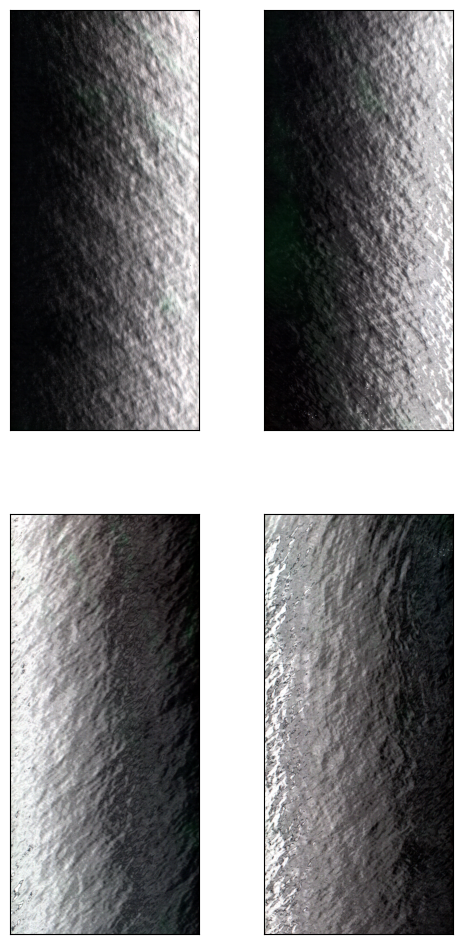

In [10]:
# Show reference images used for glint correction
fig,axs = plt.subplots(nrows=2,ncols=2, figsize=(6,12))
ref_image_paths = [pipeline.ql_im_paths[i] for i in pipeline.config.radiance_gc.reference_image_numbers]
for ax,ref_image_path in zip(chain.from_iterable(axs),ref_image_paths):
    ax.set_xticks([])
    ax.set_yticks([])
    image = ax.imshow(imread(ref_image_path))
plt.show()

In [11]:
# Run pipeline to create glint corrected images from radiance images
pipeline.glint_correct_radiance_images()

23:03:10 INFO: ---- RADIANCE GLINT CORRECTION ----
23:03:10 INFO: Glint corrected radiance images already exist - skipping


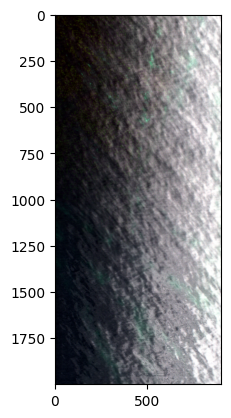

In [12]:
fig = plt.figure()
plt.imshow(imread(pipeline.ql_im_paths[example_image_number]))
plt.show()

In [13]:
# Read example hyperspectral image, before and after glint correction
hyspec_im_orig = massipipe.utils.read_envi(pipeline.rad_im_paths[example_image_number])
hyspec_im_orig, wl_orig, metadata_orig = hyspec_im_orig # Unpack multiple return args

hyspec_im_gc = massipipe.utils.read_envi(pipeline.rad_gc_im_paths[example_image_number])
hyspec_im_gc, wl_gc, metadata_gc = hyspec_im_gc # Unpack multiple return args


In [14]:
print(f"{wl_orig=}")

wl_orig=array([ 390.86,  392.87,  394.88,  396.89,  398.9 ,  400.91,  402.92,
        404.93,  406.94,  408.96,  410.97,  412.99,  415.  ,  417.02,
        419.04,  421.06,  423.08,  425.1 ,  427.12,  429.14,  431.17,
        433.19,  435.22,  437.24,  439.27,  441.3 ,  443.33,  445.36,
        447.39,  449.42,  451.45,  453.49,  455.52,  457.56,  459.59,
        461.63,  463.67,  465.71,  467.75,  469.79,  471.83,  473.87,
        475.91,  477.96,  480.  ,  482.05,  484.1 ,  486.14,  488.19,
        490.24,  492.29,  494.34,  496.39,  498.45,  500.5 ,  502.56,
        504.61,  506.67,  508.73,  510.79,  512.84,  514.9 ,  516.97,
        519.03,  521.09,  523.15,  525.22,  527.29,  529.35,  531.42,
        533.49,  535.56,  537.63,  539.7 ,  541.77,  543.84,  545.92,
        547.99,  550.07,  552.14,  554.22,  556.3 ,  558.38,  560.46,
        562.54,  564.62,  566.7 ,  568.78,  570.87,  572.95,  575.04,
        577.13,  579.21,  581.3 ,  583.39,  585.48,  587.58,  589.67,
        591.76,  593.85,  595.95,  598.05,  600.14,  602.24,  604.34,
        606.44,  608.54,  610.64,  612.74,  614.85,  616.95,  619.05,
        621.16,  623.27,  625.37,  627.48,  629.59,  631.7 ,  633.81,
        635.92,  638.04,  640.15,  642.27,  644.38,  646.5 ,  648.62,
        650.73,  652.85,  654.97,  657.09,  659.22,  661.34,  663.46,
        665.59,  667.71,  669.84,  671.96,  674.09,  676.22,  678.35,
        680.48,  682.61,  684.75,  686.88,  689.01,  691.15,  693.28,
        695.42,  697.56,  699.7 ,  701.84,  703.98,  706.12,  708.26,
        710.41,  712.55,  714.69,  716.84,  718.99,  721.13,  723.28,
        725.43,  727.58,  729.73,  731.89,  734.04,  736.19,  738.35,
        740.5 ,  742.66,  744.82,  746.98,  749.14,  751.3 ,  753.46,
        755.62,  757.78,  759.94,  762.11,  764.27,  766.44,  768.61,
        770.78,  772.95,  775.12,  777.29,  779.46,  781.63,  783.8 ,
        785.98,  788.15,  790.33,  792.51,  794.69,  796.86,  799.04,
        801.22,  803.41,  805.59,  807.77,  809.96,  812.14,  814.33,
        816.51,  818.7 ,  820.89,  823.08,  825.27,  827.46,  829.65,
        831.85,  834.04,  836.24,  838.43,  840.63,  842.83,  845.03,
        847.22,  849.42,  851.63,  853.83,  856.03,  858.23,  860.44,
        862.65,  864.85,  867.06,  869.27,  871.48,  873.69,  875.9 ,
        878.11,  880.32,  882.54,  884.75,  886.97,  889.18,  891.4 ,
        893.62,  895.84,  898.06,  900.28,  902.5 ,  904.72,  906.94,
        909.17,  911.39,  913.62,  915.85,  918.08,  920.3 ,  922.53,
        924.76,  927.  ,  929.23,  931.46,  933.7 ,  935.93,  938.17,
        940.4 ,  942.64,  944.88,  947.12,  949.36,  951.6 ,  953.84,
        956.09,  958.33,  960.58,  962.82,  965.07,  967.32,  969.56,
        971.81,  974.06,  976.31,  978.57,  980.82,  983.07,  985.33,
        987.58,  989.84,  992.1 ,  994.36,  996.62,  998.88, 1001.14,
       1003.4 , 1005.66, 1007.92, 1010.19, 1012.45, 1014.72, 1016.99,
       1019.26, 1021.52, 1023.79, 1026.07, 1028.34, 1030.61])

In [15]:
print(f"{wl_gc=}")

wl_gc=array([400.91, 402.92, 404.93, 406.94, 408.96, 410.97, 412.99, 415.  ,
       417.02, 419.04, 421.06, 423.08, 425.1 , 427.12, 429.14, 431.17,
       433.19, 435.22, 437.24, 439.27, 441.3 , 443.33, 445.36, 447.39,
       449.42, 451.45, 453.49, 455.52, 457.56, 459.59, 461.63, 463.67,
       465.71, 467.75, 469.79, 471.83, 473.87, 475.91, 477.96, 480.  ,
       482.05, 484.1 , 486.14, 488.19, 490.24, 492.29, 494.34, 496.39,
       498.45, 500.5 , 502.56, 504.61, 506.67, 508.73, 510.79, 512.84,
       514.9 , 516.97, 519.03, 521.09, 523.15, 525.22, 527.29, 529.35,
       531.42, 533.49, 535.56, 537.63, 539.7 , 541.77, 543.84, 545.92,
       547.99, 550.07, 552.14, 554.22, 556.3 , 558.38, 560.46, 562.54,
       564.62, 566.7 , 568.78, 570.87, 572.95, 575.04, 577.13, 579.21,
       581.3 , 583.39, 585.48, 587.58, 589.67, 591.76, 593.85, 595.95,
       598.05, 600.14, 602.24, 604.34, 606.44, 608.54, 610.64, 612.74,
       614.85, 616.95, 619.05, 621.16, 623.27, 625.37, 627.48, 629.59,
       631.7 , 633.81, 635.92, 638.04, 640.15, 642.27, 644.38, 646.5 ,
       648.62, 650.73, 652.85, 654.97, 657.09, 659.22, 661.34, 663.46,
       665.59, 667.71, 669.84, 671.96, 674.09, 676.22, 678.35, 680.48,
       682.61, 684.75, 686.88, 689.01, 691.15, 693.28, 695.42, 697.56,
       699.7 , 701.84, 703.98, 706.12, 708.26, 710.41, 712.55, 714.69,
       716.84, 718.99, 721.13, 723.28, 725.43, 727.58, 729.73])

In [16]:
# Get RGB versions of hyperspectral images
hyspec_orig_rgb,rgb_wl = massipipe.utils.rgb_subset_from_hsi(hyspec_im_orig,wl_orig)
hyspec_gc_rgb,_ = massipipe.utils.rgb_subset_from_hsi(hyspec_im_gc,wl_gc)


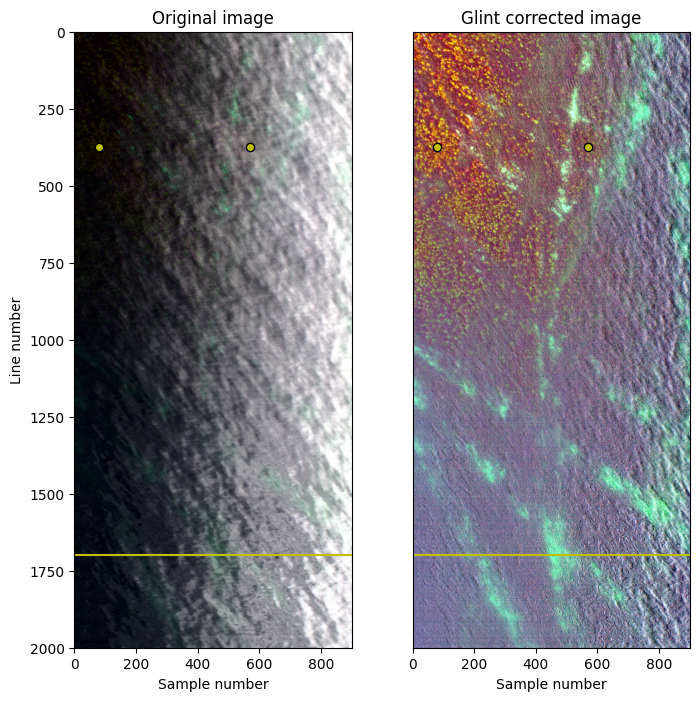

In [17]:
fig,axs = plt.subplots(ncols=2,figsize=(8,8))
for ax,rgb_im in zip(axs,[hyspec_orig_rgb,hyspec_gc_rgb]):
    ax.imshow(massipipe.utils.percentile_stretch_image(rgb_im))
    ax.set_xlim([0,900])
    ax.set_ylim([2000,0])

axs[0].set_title("Original image")
axs[1].set_title("Glint corrected image")
axs[0].set_ylabel("Line number")
axs[0].set_xlabel("Sample number")
axs[1].set_xlabel("Sample number")
axs[1].set_yticks([])

# Save before drawing points and lines
plt.savefig(figures_dir / "original_and_glint_corrected_rgb_image.png",dpi=300)

for ax,rgb_im in zip(axs,[hyspec_orig_rgb,hyspec_gc_rgb]):
    ax.plot([0,900],[slice_row_index]*2,color="y")
    ax.scatter(point_col_indices,[point_row_index]*2,color="y",edgecolors="k")

plt.show()

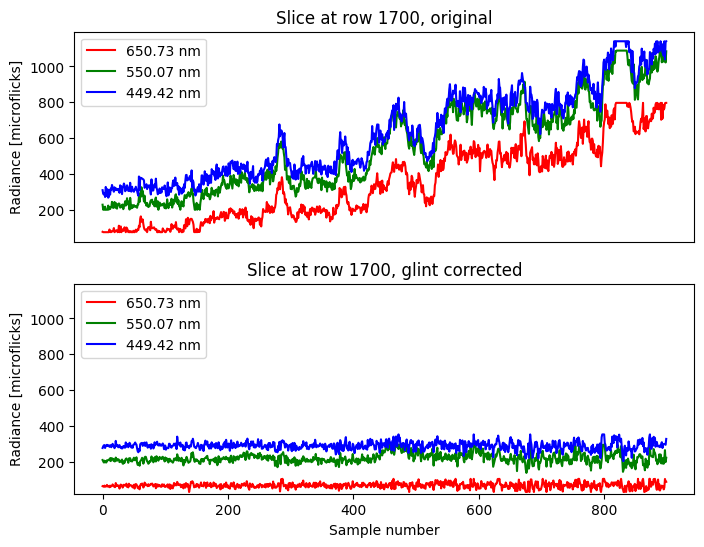

In [18]:
fig,axs = plt.subplots(nrows=2,figsize=(8,6))
for ax,rgb_im in zip(axs,[hyspec_orig_rgb,hyspec_gc_rgb]):
    rgb_im_slice = rgb_im[1750,:,:].T
    for band,color,label in zip(rgb_im_slice,("r","g","b"),[f"{wl} nm" for wl in rgb_wl]):
        ax.plot(band,color=color,label=label)
    ax.legend(loc="upper left")
axs[1].set_ylim(axs[0].get_ylim())
axs[0].set_xticks([])
axs[1].set_xlabel("Sample number")
axs[0].set_ylabel("Radiance [microflicks]")
axs[1].set_ylabel("Radiance [microflicks]")
axs[0].set_title(f"Slice at row {slice_row_index}, original")
axs[1].set_title(f"Slice at row {slice_row_index}, glint corrected")

plt.savefig(figures_dir / "original_and_glint_corrected_rgb_slice.png",dpi=300)

plt.show()

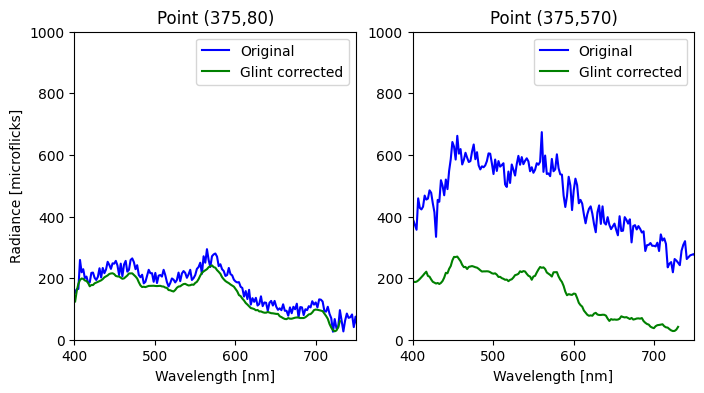

In [19]:
fig,axs = plt.subplots(ncols=2,figsize=(8,4))
for ax,pixel_x in zip(axs,[100,550]):
    ax.plot(wl_orig,hyspec_im_orig[375,pixel_x,:],color="b",label="Original")
    ax.plot(wl_gc,hyspec_im_gc[375,pixel_x,:],color="g",label="Glint corrected")
    ax.set_xlim([400,750])
    ax.set_ylim([0,1000])
    ax.legend(loc="upper right")
axs[0].set_title(f"Point ({point_row_index},{point_col_indices[0]})")
axs[1].set_title(f"Point ({point_row_index},{point_col_indices[1]})")
axs[0].set_ylabel("Radiance [microflicks]")
axs[0].set_xlabel("Wavelength [nm]")
axs[1].set_xlabel("Wavelength [nm]")

plt.savefig(figures_dir / "original_and_glint_corrected_point_spectra.png",dpi=300)

plt.show()